For this charge scaling notebook ONLY start to end tracking can be used. I don't think the CSR effects in BC14 can be ignored so the charge needs to evolve there too

A complication with this approach is that the wakefields also scale with charge... therefore, do not expect the CSR-off case to match a CSR-on-zero-charge case

In [1]:
from UTILITY_quickstart import *

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
csrTF = True
evalElement = "PENT"

initialCharge = 1.0e-12
finalCharge = 1.6e-9
newCharge = initialCharge
chargeScalingSteps = 1000


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e3,
)

trackBeam(tao, trackEnd = "L0BFEND", verbose = True)

#Rescale charge
P = getBeamAtElement(tao, "L0AFEND")
print(f"""As imported charge: {P.charge}""")
P.charge = newCharge
makeBeamActiveBeamFile(P)
tao.cmd('reinit beam')

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

print(f"""PInit charge: {PInit.charge}""")

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 1000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting
As imported charge: 1.5999999999999999e-09
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting
PInit charge: 1.0000000000000002e-12


In [3]:
# PInit = ParticleGroup("./beams/2024-10-14_Impact_TwoBunch/2024-10-14_TwoBunch.h5")
# makeBeamActiveBeamFile(PInit)

In [4]:
targetBunchSpacing = 150e-6

#masterToleranceScaling = 1.0 #Higher is looser; generally tighten for early sims and loosen for refinement
masterToleranceScalingStart = 1.0
masterToleranceScalingEnd = 1.0
masterToleranceScalingEvolutionSteps = 1000
masterToleranceScaling = masterToleranceScalingStart

stageOneOptimization    = 0  # Disabling transverse terms and length limits, per https://docs.google.com/presentation/d/1b6WoEwmDz5cA0fm9FbbGiZoMwBcbCNNNCsD7JiFDxRc/edit#slide=id.g2f91233284b_0_0
enableAlignmentTerms    = 0  # Enable centroid offset and angle penalties. Useful for removing final focus kickers from free parameters
enableLongitudinalTerms = 1  # Enable bunch spacing penalty and bunch length objectives 

usingCheckpoint = False #For this charge scaling notebook ONLY start to end tracking can be used.
#checkpointElement = "MFFF"
#checkpointElement = "IM1988" #Shortly upstream of BEGBC20
checkpointElement = "CB1LE" #Shortly downstream of BEGBC20; there's an intervening dipole though
checkpointElementS = tao.ele_param(checkpointElement,"ele.s")['ele_s']
centerBC14 = True 
centerBC20 = True

#If the checkpoint is DOWNSTREAM of the centering location AND you want centering, set True
centerBC14ForCheckpoint = True and (checkpointElementS > tao.ele_param("BEGBC14_1","ele.s")['ele_s'])
centerBC20ForCheckpoint = True and (checkpointElementS > tao.ele_param("BEGBC20","ele.s")['ele_s'])

#If the checkpoint is UPSTREAM of the centering location AND you want centering, set True
centerBC14ForRemainder = centerBC14 and not centerBC14ForCheckpoint
centerBC20ForRemainder = centerBC20 and not centerBC20ForCheckpoint

if usingCheckpoint:
    print(f"Using checkpoint: {checkpointElement}")
    print(f"centerBC14ForCheckpoint = {centerBC14ForCheckpoint}, centerBC20ForCheckpoint = {centerBC20ForCheckpoint}")
    print(f"centerBC14ForRemainder = {centerBC14ForRemainder}, centerBC20ForRemainder = {centerBC20ForRemainder}")
else:
    print("No checkpoint. Start to end tracking")
    print(f"centerBC14 = {centerBC14}, centerBC20 = {centerBC20}")


pbounds = {
    # "QA10361kG": eval(importedDefaultSettings["QA10361kGBounds"]),
    # "QA10371kG": eval(importedDefaultSettings["QA10371kGBounds"]),
    # "QE10425kG": eval(importedDefaultSettings["QE10425kGBounds"]),
    # "QE10441kG": eval(importedDefaultSettings["QE10441kGBounds"]),
    # "QE10511kG": eval(importedDefaultSettings["QE10511kGBounds"]),
    # "QE10525kG": eval(importedDefaultSettings["QE10525kGBounds"]),

    'L0BPhaseSet': (-30, 30),
    'L1PhaseSet': (-60, 0),
    'L2PhaseSet': (-60, 0),
    # 'L3PhaseSet': (-15, 15),
    
    # 'L0BEnergyOffset': (-5e6, 5e6),
    # 'L1EnergyOffset': (-10e6, 10e6),
    # 'L2EnergyOffset': (-500e6, 500e6),
    # 'L3EnergyOffset': (-500e6, 500e6),

    # "Q1EkG":  eval(importedDefaultSettings["Q1EkGBounds"]),
    # "Q2EkG":  eval(importedDefaultSettings["Q2EkGBounds"]),
    # "Q3EkG":  eval(importedDefaultSettings["Q3EkGBounds"]),
    # "Q4EkG":  eval(importedDefaultSettings["Q4EkGBounds"]),
    # "Q5EkG":  eval(importedDefaultSettings["Q5EkGBounds"]),
    # "Q6EkG":  eval(importedDefaultSettings["Q6EkGBounds"]),
    
    "S1ELkG": eval(importedDefaultSettings["S1ELkGBounds"]),
    "S2ELkG": eval(importedDefaultSettings["S2ELkGBounds"]),
    "S3ELkG": eval(importedDefaultSettings["S3ELkGBounds"]),
    "S3ERkG": eval(importedDefaultSettings["S3ERkGBounds"]),
    "S2ERkG": eval(importedDefaultSettings["S2ERkGBounds"]),
    "S1ERkG": eval(importedDefaultSettings["S1ERkGBounds"]),

    "S1EL_xOffset" : ( -0.004, 0.004 ),  
    "S1EL_yOffset" : ( -0.004, 0.004 ),  
    "S2EL_xOffset" : ( -0.004, 0.004 ),  
    "S2EL_yOffset" : ( -0.004, 0.004 ),  
    "S2ER_xOffset" : ( -0.004, 0.004 ),  
    "S2ER_yOffset" : ( -0.004, 0.004 ),  
    "S1ER_xOffset" : ( -0.004, 0.004 ),  
    "S1ER_yOffset" : ( -0.004, 0.004 ),

    # # 'Q5FFkG': eval(importedDefaultSettings["Q5FFkGBounds"]),
    # # 'Q4FFkG': eval(importedDefaultSettings["Q4FFkGBounds"]),
    # # 'Q3FFkG': eval(importedDefaultSettings["Q3FFkGBounds"]),
    # # 'Q2FFkG': eval(importedDefaultSettings["Q2FFkGBounds"]),
    # # 'Q1FFkG': eval(importedDefaultSettings["Q1FFkGBounds"]),
    # # 'Q0FFkG': eval(importedDefaultSettings["Q0FFkGBounds"]),
    # # # 'Q0DkG':  eval(importedDefaultSettings["Q0DkGBounds"]),
    # # # 'Q1DkG':  eval(importedDefaultSettings["Q1DkGBounds"]),
    # # # 'Q2DkG':  eval(importedDefaultSettings["Q2DkGBounds"]),

    "XC1FFkG" : tuple(2 * x for x in eval(importedDefaultSettings["XC1FFkGBounds"])), #2024-10-11: Extending bounds as proxy for tuning final chicane dipole strength
    "XC3FFkG" : eval(importedDefaultSettings["XC3FFkGBounds"]),
    "YC1FFkG" : eval(importedDefaultSettings["YC1FFkGBounds"]),
    "YC2FFkG" : eval(importedDefaultSettings["YC2FFkGBounds"]),
}

No checkpoint. Start to end tracking
centerBC14 = True, centerBC20 = True


# Optimization

## Utility functions

In [5]:
# #2024-08-23: Now to IM1988 to enable centering at BC20
# def propagateToBEGBC20(): 

#     ##################################
#     #Propagate to BEGBC20 and save result
#     ##################################
#     makeBeamActiveBeamFile(PInit)
    

#     trackBeam(tao, trackStart = "L0AFEND", trackEnd = "IM1988", centerBC14 = True, verbose = True)

#     P = ParticleGroup(data=tao.bunch_data("IM1988"))
    
#     makeBeamActiveBeamFile(P)

#     return


#Generalizing
def propagateFromStartToCheckpoint(
    checkpointElement,
    centerBC14,
    centerBC20
): 
    makeBeamActiveBeamFile(PInit)

    trackBeam(tao, trackStart = "L0AFEND", trackEnd = checkpointElement, centerBC14 = centerBC14, centerBC20 = centerBC20, verbose = False)

    P = ParticleGroup(data=tao.bunch_data(checkpointElement))
    
    makeBeamActiveBeamFile(P)

    return

## Optimizer functions

In [6]:
if usingCheckpoint:
    setLattice(tao) #Set lattice to current default config
    propagateFromStartToCheckpoint(checkpointElement, centerBC14ForCheckpoint, centerBC20ForCheckpoint)

def rampToZero(val, thresh, scale = 1):
    return (max(val, thresh) - thresh) / scale


def updateMasterToleranceScaling(totalNumEvals):
    """
    I'm not sure if this is actually a good idea or not. 
    The general idea I'm aiming for is that early optimization iterations will get closer to the thresholded constraints than strictly necessary, 
    allowing later optimization to proceed with more wiggle room and less likelihood of falling off a "cliff".
    Maybe it'd make more sense to make this conditional on something other than evaluation count?
    Alternatively, what if it's useful to start with looser constraints and gradually tighten them? For something like COBYQA, it's less likely to "overlearn" when trying to satisfy, e.g. the first condition
    An insane person might try using an exponentially decaying sine to try both...
    """
    
    global masterToleranceScaling

    if totalNumEvals < masterToleranceScalingEvolutionSteps: 
        masterToleranceScaling = masterToleranceScalingStart + (masterToleranceScalingEnd - masterToleranceScalingStart) * totalNumEvals / masterToleranceScalingEvolutionSteps
    else:
        masterToleranceScaling = masterToleranceScalingEnd
    
    return


def updateBeamCharge(totalNumEvals):

    global newCharge

    #Linear
    # if totalNumEvals < masterToleranceScalingEvolutionSteps: 
    #     newCharge = initialCharge + (finalCharge - initialCharge) * totalNumEvals / chargeScalingSteps
    # else:
    #     newCharge = finalCharge

    #PowerRange[]
    if totalNumEvals < masterToleranceScalingEvolutionSteps: 
        newCharge = initialCharge * np.exp( totalNumEvals * (np.log(finalCharge) - np.log(initialCharge)) / chargeScalingSteps )  
    else:
        newCharge = finalCharge


    P = getBeamAtElement(tao, "L0AFEND")
    P.charge = newCharge
    makeBeamActiveBeamFile(P)
    tao.cmd('reinit beam')
    
    return newCharge


def specificOptimizer(
    self,
    **kwargs
):

    self.totalNumEvals += 1
    self.displayEvals()

    savedData = kwargs
    
    updateMasterToleranceScaling(self.totalNumEvals)
    
    
    savedData["charge"] = updateBeamCharge(self.totalNumEvals)
    print(f"""savedData["charge"] = {savedData["charge"]}""")


    badValue = -1e30  #The value returned for illegal config. Should be colossal. Double limit ~= 1e308
    bigCost  = 1e20   #Should be large enough to dominate any "normal" return value but be dominated by badValue
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        print(f"specificOptimizer() excepted'd on setLattice()")
        return badValue * 5

    try:
        if usingCheckpoint: 
            #trackBeam(tao, trackStart = checkpointElement, trackEnd = evalElement, centerBC14 = centerBC14ForRemainder, centerBC20 = centerBC20ForRemainder, verbose = False) ##For this charge scaling notebook ONLY start to end tracking can be used.
            print("For this charge scaling notebook ONLY start to end tracking can be used.")
        else:
            trackBeam(tao, trackStart = "L0AFEND", trackEnd = evalElement, centerBC14 = centerBC14, centerBC20 = centerBC20, verbose = False)

    except:
            print(f"specificOptimizer() excepted'd on trackBeam()")
            return badValue * 4
    

    #BEGBC20NumLiveParticles = tao.bunch_params("BEGBC20")['n_particle_live']
    #PENTNumLiveParticles = tao.bunch_params("PENT")['n_particle_live']

    if tao.bunch_params(evalElement)['n_particle_live'] < 10:
        print(f"specificOptimizer() got ~no particles after tracking")
        return badValue * 2 

    

    
    try: 
        P = getBeamAtElement(tao, evalElement)
        #PDrive, PWitness = getDriverAndWitness(P)
        PDrive = P.copy()
    

        for PActiveStr in ["PDrive"]: #["PDrive", "PWitness"]: #, "PSystem"]:
            PActive = locals()[PActiveStr]
            for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
                savedData[f"{PActiveStr}_{val}"] = PActive[val]
                #print(f"""{PActiveStr}_{val} = {PActive[val]}""")


            savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
            savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)

            savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
            savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
            
            savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
            savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)
            savedData[f"{PActiveStr}_sigmaSI90_z"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

            savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
            savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

            savedData[f"{PActiveStr}_norm_emit_x"] = PActive["norm_emit_x"]
            savedData[f"{PActiveStr}_norm_emit_y"] = PActive["norm_emit_y"]

            #savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

            savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

        # savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

        # savedData["transverseCentroidOffset"] = np.sqrt(
        #         (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
        #         (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
        #     )

        
        #savedData["lostChargeFraction"] = 1 - (tao.bunch_params("DTOTR")['n_particle_live'] / tao.bunch_params("BEGBC20")['n_particle_live'])
        #savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)
        #Special for charge varying notebook:
        savedData["lostChargeFraction"] = 1 - (P.charge / savedData["charge"])
            

    except:
        print(f"specificOptimizer() excepted'd while getting beam and compiling savedData")
        return badValue


    if stageOneOptimization: 
        enableTransverse = 0
        lengthLimitMultiplier = 0
        stageOneSpacingToleranceMultiplier = 0.5

    else:
        enableTransverse = 1
        lengthLimitMultiplier = 1

    

    
    tolerableBeamLossFraction  = 0.02  * masterToleranceScaling
    tolerableBunchSpacingError = 100e-6 * masterToleranceScaling * (stageOneSpacingToleranceMultiplier if stageOneOptimization else 1.0)
    
    tolerableBeamOffset  = 5e-6 * masterToleranceScaling
    tolerableAngleOffset = 5e-3 * masterToleranceScaling
    

    driveEmittanceThreshold   = 50e-6 * masterToleranceScaling
    witnessEmittanceThreshold = 20e-6 * masterToleranceScaling

    driveSpotThreshold     = 10e-6 #* masterToleranceScaling
    witnessSpotThreshold   = 30e-6 #* masterToleranceScaling
    
    driveLengthThreshold   = lengthLimitMultiplier * 10e-6 #* masterToleranceScaling
    witnessLengthThreshold = lengthLimitMultiplier * 20e-6 #* masterToleranceScaling


    savedData["errorTerm_lostChargeFraction"] = 1e3 * rampToZero( savedData["lostChargeFraction"], tolerableBeamLossFraction, scale = 0.01)**2
    
    #savedData["errorTerm_bunchSpacing"] = enableLongitudinalTerms * 1e3 * rampToZero( abs(savedData["bunchSpacing"] - targetBunchSpacing), tolerableBunchSpacingError, scale = 10e-6)**2
    
    savedData["errorTerm_transverseOffset"] = enableAlignmentTerms * enableTransverse * 1e3 * np.mean([
                #rampToZero(abs(savedData["PWitness_median_x"]), tolerableBeamOffset, scale = 1e-6) ** 2,
                #rampToZero(abs(savedData["PWitness_median_y"]), tolerableBeamOffset, scale = 1e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_x"]  ), tolerableBeamOffset, scale = 1e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_y"]  ), tolerableBeamOffset, scale = 1e-6) ** 2,
    ])
    
    savedData["errorTerm_angleOffset"] = enableAlignmentTerms * enableTransverse * 1e3 * np.mean([
                #rampToZero(abs(savedData["PWitness_median_xp"]), tolerableAngleOffset, scale = 100e-6) ** 2,
                #rampToZero(abs(savedData["PWitness_median_yp"]), tolerableAngleOffset, scale = 100e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_xp"]  ), tolerableAngleOffset, scale = 100e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_yp"]  ), tolerableAngleOffset, scale = 100e-6) ** 2,
    ])
    
    # savedData["errorTerm_mainObjective"] = max([
    #             savedData[f"PDrive_sigmaSI90_x"],savedData[f"PDrive_sigmaSI90_y"],savedData[f"PDrive_zLen"],
    #             savedData[f"PWitness_sigmaSI90_x"],savedData[f"PWitness_sigmaSI90_y"],savedData[f"PWitness_zLen"]
    # ]) / 10e-6

    savedData["errorTerm_mainObjective"] = np.mean([
                enableTransverse *        rampToZero(savedData[f"PDrive_sigmaSI90_x"],   driveSpotThreshold,     10e-6) ** 2,
                enableTransverse *        rampToZero(savedData[f"PDrive_sigmaSI90_y"],   driveSpotThreshold,     10e-6) ** 2,
                enableLongitudinalTerms * rampToZero(savedData[f"PDrive_sigmaSI90_z"],   driveLengthThreshold,   10e-6) ** 2,

                #enableTransverse *                          rampToZero(savedData[f"PWitness_sigmaSI90_x"], witnessSpotThreshold,   10e-6) ** 2,
                #enableTransverse *                          rampToZero(savedData[f"PWitness_sigmaSI90_y"], witnessSpotThreshold,   10e-6) ** 2,
                #enableLongitudinalTerms *                   rampToZero(savedData[f"PWitness_sigmaSI90_z"], witnessLengthThreshold, 10e-6) ** 2,

                # rampToZero(savedData[f"PDrive_emitSI90_x"], 0, 10e-6) ** 2,
                # rampToZero(savedData[f"PDrive_emitSI90_y"], 0, 10e-6) ** 2,

                # rampToZero(savedData[f"PDrive_norm_emit_x"], 0, 10e-6) ** 2,
                # rampToZero(savedData[f"PDrive_norm_emit_y"], 0, 10e-6) ** 2,
    ]) 

    #Secondary objective includes all "ramp" terms with thresholds disabled. Intended to gently nudge all specs to better values if nothing else is going on; mostly expect this to do anything once thresholds are hit
    #2024-10-15 comment: Advise not setting this weight above 1e-6. For quite-good mainObjective settings, even 1e-4 is too much
    savedData["errorTerm_secondaryObjective"] = 1e-6 * np.mean([
                #rampToZero( abs(savedData["bunchSpacing"] - targetBunchSpacing), 0 * tolerableBunchSpacingError, scale = 10e-6)**2,
        
                #rampToZero(abs(savedData["PWitness_median_x"]),                  0 * tolerableBeamOffset, scale = 1e-6) ** 2,
                #rampToZero(abs(savedData["PWitness_median_y"]),                  0 * tolerableBeamOffset, scale = 1e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_x"]  ),                  0 * tolerableBeamOffset, scale = 1e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_y"]  ),                  0 * tolerableBeamOffset, scale = 1e-6) ** 2,

                #rampToZero(abs(savedData["PWitness_median_xp"]),                 0 * tolerableAngleOffset, scale = 100e-6) ** 2,
                #rampToZero(abs(savedData["PWitness_median_yp"]),                 0 * tolerableAngleOffset, scale = 100e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_xp"]  ),                 0 * tolerableAngleOffset, scale = 100e-6) ** 2,
                rampToZero(abs(savedData["PDrive_median_yp"]  ),                 0 * tolerableAngleOffset, scale = 100e-6) ** 2,

                rampToZero(savedData[f"PDrive_sigmaSI90_x"],                     0 * driveSpotThreshold,     10e-6) ** 2,
                rampToZero(savedData[f"PDrive_sigmaSI90_y"],                     0 * driveSpotThreshold,     10e-6) ** 2,
                rampToZero(savedData[f"PDrive_sigmaSI90_z"],                     0 * driveLengthThreshold,   10e-6) ** 2,
                #rampToZero(savedData[f"PWitness_sigmaSI90_x"],                   0 * witnessSpotThreshold,   10e-6) ** 2,
                #rampToZero(savedData[f"PWitness_sigmaSI90_y"],                   0 * witnessSpotThreshold,   10e-6) ** 2,
                #rampToZero(savedData[f"PWitness_sigmaSI90_z"],                   0 * witnessLengthThreshold, 10e-6) ** 2,
    ])
    
    savedData["maximizeMe"] = 1 / np.mean([
        savedData["errorTerm_lostChargeFraction"], 
        #savedData["errorTerm_bunchSpacing"],
        savedData["errorTerm_transverseOffset"],
        savedData["errorTerm_angleOffset"],
        savedData["errorTerm_mainObjective"],
        savedData["errorTerm_secondaryObjective"],
        1e-20 #Avoid infinities 
    ])

    savedData["inputBeamFilePathSuffix"] = inputBeamFilePathSuffix
    savedData["csrTF"] = csrTF
    

    
    #Collect desired data as a pandas Series
    tmpData = pd.Series( savedData ) 
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    #Optional: Write to file
    self.history.to_json('optimizerHistory.json', orient='records')
    
    self.updatePlot()

    return savedData["maximizeMe"]




# Function to create optimizerWrapper based on pbounds
def create_optimizer_wrapper(pbounds):
    param_names = list(pbounds.keys())
    
    def optimizerWrapper(self, **kwargs):
        params = {name: kwargs.get(name, None) for name in param_names}
        if None in params.values():
            raise ValueError("All parameters must be provided")
        return specificOptimizer(self, **params)
    
    return optimizerWrapper

# Create the optimizerWrapper function
optimizerWrapper = create_optimizer_wrapper(pbounds)

### General optimizer setup

In [7]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None


    def updatePlot(self):
        plt.figure()
        plotKey = "maximizeMe"
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        
        if self.plot_display_handle is None:
            self.plot_display_handle = display(plt.gcf(), display_id=True)
        else:
            update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
        plt.close()

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            #Can't use '\n' in this context. <br> doesn't work either
            update_display(f"Total Num Evals: {self.totalNumEvals}, masterToleranceScaling: {masterToleranceScaling}, newCharge: {newCharge}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

In [8]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evolution is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

In [9]:
defaultSettingsVector = [importedDefaultSettings[key] for key in list(pbounds.keys())]

## Run optimizer

In [10]:
from IPython.display import HTML, display

if usingCheckpoint:
    display(HTML(f'<span style="color: red; font-size: 18px;">Checkpoint enabled: {checkpointElement}</span>'))
else:
    display(HTML('<span style="color: green; font-size: 18px;">No checkpoint. Start-to-end simulation</span>'))

if masterToleranceScalingStart == masterToleranceScalingEnd == 1.0:
    display(HTML('<span style="color: green; font-size: 18px;">No masterToleranceScaling</span>'))
else:
    display(HTML('<span style="color: red; font-size: 18px;">masterToleranceScaling is changing</span>'))

if csrTF:
    display(HTML('<span style="color: green; font-size: 18px;">CSR enabled</span>'))
else:
    display(HTML('<span style="color: red; font-size: 18px;">CSR disabled</span>'))

if evalElement == "PENT":
    display(HTML('<span style="color: green; font-size: 18px;">Evaluation at PENT</span>'))
else:
    display(HTML(f'<span style="color: red; font-size: 18px;">Evaluation at {evalElement}, not PENT</span>'))

if stageOneOptimization:
    display(HTML('<span style="color: red; font-size: 18px;">Stage 1 optimization disables spot size, angle, and offset penalties </span>'))

if not enableAlignmentTerms:
    display(HTML('<span style="color: red; font-size: 18px;">Offset and angle penalties disabled</span>'))

if not enableLongitudinalTerms:
    display(HTML('<span style="color: red; font-size: 18px;">Bunch spacing and length terms disabled</span>'))



'Total Num Evals: 178, masterToleranceScaling: 1.0, newCharge: 3.6908741490425695e-12'

savedData["charge"] = 1.0074050416253135e-12


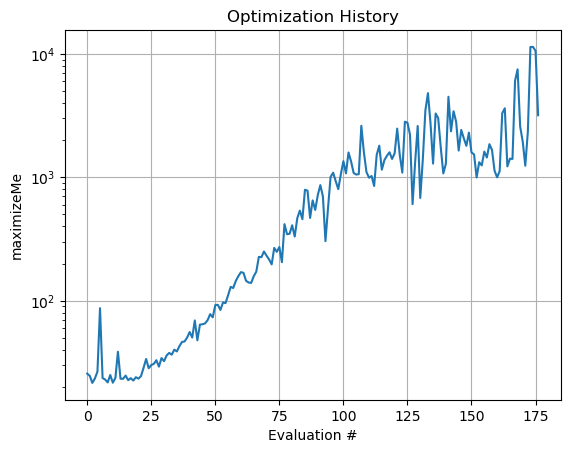

savedData["charge"] = 1.0148649178920998e-12
savedData["charge"] = 1.0223800348531613e-12
savedData["charge"] = 1.0299508015681387e-12
savedData["charge"] = 1.0375776301257757e-12
savedData["charge"] = 1.0452609356663513e-12
savedData["charge"] = 1.053001136404275e-12
savedData["charge"] = 1.0607986536508512e-12
savedData["charge"] = 1.0686539118372122e-12
savedData["charge"] = 1.076567338537421e-12
savedData["charge"] = 1.0845393644917439e-12
savedData["charge"] = 1.0925704236300963e-12
savedData["charge"] = 1.1006609530956637e-12
savedData["charge"] = 1.1088113932686944e-12
savedData["charge"] = 1.1170221877904711e-12
savedData["charge"] = 1.1252937835874582e-12
savedData["charge"] = 1.1336266308956302e-12
savedData["charge"] = 1.1420211832849765e-12
savedData["charge"] = 1.1504778976841915e-12
savedData["charge"] = 1.1589972344055464e-12
savedData["charge"] = 1.1675796571699427e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.1762256331321554e-12
savedData["charge"] = 1.18493563290626e-12
savedData["charge"] = 1.1937101305912482e-12
savedData["charge"] = 1.2025496037968349e-12
savedData["charge"] = 1.2114545336694549e-12
savedData["charge"] = 1.2204254049184521e-12
savedData["charge"] = 1.2294627058424633e-12
savedData["charge"] = 1.2385669283559976e-12
savedData["charge"] = 1.2477385680162105e-12
savedData["charge"] = 1.2569781240498798e-12
savedData["charge"] = 1.2662860993805779e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.2756630006560469e-12
savedData["charge"] = 1.2851093382757775e-12
savedData["charge"] = 1.2946256264187886e-12
savedData["charge"] = 1.3042123830716176e-12
savedData["charge"] = 1.3138701300565125e-12
savedData["charge"] = 1.3235993930598371e-12
savedData["charge"] = 1.333400701660685e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.3432745893597048e-12
savedData["charge"] = 1.3532215936081396e-12
savedData["charge"] = 1.3632422558370808e-12
savedData["charge"] = 1.373337121486941e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.38350674003714e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.3937516650360172e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.404072454130959e-12
savedData["charge"] = 1.414469669098755e-12
savedData["charge"] = 1.4249438758761747e-12
savedData["charge"] = 1.4354956445907736e-12
savedData["charge"] = 1.4461255495919248e-12
savedData["charge"] = 1.4568341694820825e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.4676220871482763e-12
savedData["charge"] = 1.478489889793839e-12
savedData["charge"] = 1.4894381689703676e-12
savedData["charge"] = 1.5004675206099242e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.5115785450574717e-12
savedData["charge"] = 1.5227718471035534e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.5340480360172109e-12
savedData["charge"] = 1.5454077255791489e-12
savedData["charge"] = 1.5568515341151439e-12
savedData["charge"] = 1.5683800845296997e-12
savedData["charge"] = 1.579994004339955e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.5916939257098384e-12
savedData["charge"] = 1.6034804854844785e-12
savedData["charge"] = 1.6153543252248692e-12
savedData["charge"] = 1.6273160912427897e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.6393664346359854e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.6515060113236068e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.6637354820819136e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.6760555125802414e-12
savedData["charge"] = 1.6884667734172345e-12
savedData["charge"] = 1.7009699401573481e-12
savedData["charge"] = 1.7135656933676205e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.726254718654717e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.7390377067022492e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.7519153533083693e-12
savedData["charge"] = 1.7648883594236436e-12
savedData["charge"] = 1.7779574311892072e-12
savedData["charge"] = 1.791123279975199e-12
savedData["charge"] = 1.8043866224194837e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.8177481804666591e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.8312086814073526e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.8447688579178097e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.8584294480997733e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.8721911955206605e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.886054849254037e-12
savedData["charge"] = 1.9000211639203875e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.914090899728195e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.9282648225153163e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.94254370379067e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.956928320776231e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.971419456449334e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 1.9860178995852946e-12
savedData["charge"] = 2.000724444800341e-12
savedData["charge"] = 2.0155398925948704e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.030465049397016e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.0455007276065448e-12
savedData["charge"] = 2.0606477456390804e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.0759069279706467e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.0912791051825465e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.1067651140065713e-12
savedData["charge"] = 2.122365797370549e-12
savedData["charge"] = 2.1380820044442197e-12
savedData["charge"] = 2.153914590685463e-12
savedData["charge"] = 2.1698644178868594e-12
savedData["charge"] = 2.1859323542225986e-12
savedData["charge"] = 2.2021192742957364e-12
savedData["charge"] = 2.2184260591858015e-12
savedData["charge"] = 2.234853596496753e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.251402780405293e-12
savedData["charge"] = 2.268074511709541e-12
savedData["charge"] = 2.284869697878063e-12
savedData["charge"] = 2.3017892530992684e-12
savedData["charge"] = 2.318834098331168e-12
savedData["charge"] = 2.3360051613515065e-12
savedData["charge"] = 2.3533033768082617e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.3707296862705186e-12
savedData["charge"] = 2.388285038279718e-12
savedData["charge"] = 2.405970388401293e-12
savedData["charge"] = 2.423786699276677e-12
savedData["charge"] = 2.4417349406757014e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.4598160895493877e-12
savedData["charge"] = 2.4780311300831177e-12
savedData["charge"] = 2.496381053750206e-12
savedData["charge"] = 2.5148668593658704e-12
savedData["charge"] = 2.5334895531415965e-12
savedData["charge"] = 2.5522501487399073e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.5711496673295386e-12
savedData["charge"] = 2.5901891376410252e-12
savedData["charge"] = 2.6093695960226927e-12
savedData["charge"] = 2.6286920864970683e-12
savedData["charge"] = 2.6481576608177115e-12
savedData["charge"] = 2.6677673785264597e-12
savedData["charge"] = 2.687522307011102e-12
savedData["charge"] = 2.707423521563478e-12
savedData["charge"] = 2.7274721054380092e-12
savedData["charge"] = 2.747669149910659e-12
savedData["charge"] = 2.768015754338337e-12
savedData["charge"] = 2.788513026218737e-12
savedData["charge"] = 2.809162081250616e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 2.8299640433945295e-12
savedData["charge"] = 2.8509200449340064e-12
savedData["charge"] = 2.8720312265371844e-12
savedData["charge"] = 2.893298737318892e-12
savedData["charge"] = 2.914723734903206e-12
savedData["charge"] = 2.936307385486454e-12
savedData["charge"] = 2.9580508639006967e-12
savedData["charge"] = 2.979955353677676e-12
savedData["charge"] = 3.0020220471132355e-12
savedData["charge"] = 3.024252145332218e-12
savedData["charge"] = 3.0466468583538472e-12
savedData["charge"] = 3.0692074051575884e-12
savedData["charge"] = 3.091935013749501e-12
savedData["charge"] = 3.1148309212290804e-12
savedData["charge"] = 3.1378963738565958e-12
savedData["charge"] = 3.1611326271209244e-12
savedData["charge"] = 3.1845409458078917e-12
savedData["charge"] = 3.208122604069115e-12
savedData["charge"] = 3.231878885491356e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 3.255811083166393e-12
savedData["charge"] = 3.279920499761397e-12
savedData["charge"] = 3.3042084475898498e-12
savedData["charge"] = 3.3286762486829655e-12
savedData["charge"] = 3.3533252348616552e-12
savedData["charge"] = 3.3781567478090203e-12
savedData["charge"] = 3.4031721391433804e-12
savedData["charge"] = 3.4283727704918445e-12
savedData["charge"] = 3.453760013564428e-12
savedData["charge"] = 3.4793352502287167e-12
savedData["charge"] = 3.505099872585081e-12
savedData["charge"] = 3.5310552830424548e-12
savedData["charge"] = 3.5572028943946682e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 3.5835441298973465e-12
savedData["charge"] = 3.610080423345384e-12
savedData["charge"] = 3.6368132191509873e-12


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


savedData["charge"] = 3.66374397242229e-12
savedData["charge"] = 3.6908741490425695e-12
savedData["charge"] = 3.718205225750024e-12


In [ ]:
from scipy.optimize import minimize

#optimizationType = "differentialEvolution" #Classic, standard for exploration
optimizationType = "nelderMead"            #Classic, standard for refinement
#optimizationType = "L-BFGS-B"              #This never seems to work; I think the problem is too noisy to get a reasonable Hessian
#optimizationType = "powell"                #This rarely seems to help; I think the orthogonal approach is not appropriate for this problem
#optimizationType = "COBYQA"                #Seems promising. Not timid about making big, coordinated moves. I like it more for refinement though. Seems (much) more likely than nelderMead to give up too early though...
#optimizationType = "bayesian"              #This uses a different library, different signature, different objective, different bounds, etc... beware!

match optimizationType:

    case "differentialEvolution":
        totalPopSize = 20            # Total population size
        numDimensions = len(bounds)  # Number of parameters
        
        initializationType = "uniform"
        #initializationType = "normal"
        
        match initializationType:
        
            case "uniform":
                populationDE = np.random.rand(totalPopSize, numDimensions)
                for i in range(numDimensions):
                    low, high = bounds[i]
                    populationDE[:, i] = low + populationDE[:, i] * (high - low)  
                    
            case "normal":
                populationDE = np.zeros((totalPopSize, numDimensions))
                for i in range(numDimensions):
                    low, high = bounds[i]
                
                    #Define mean based on bounds
                    #mean = (high + low) / 2
                
                    #Optional: Define mean based on defaultSettingsVector
                    mean = defaultSettingsVector[i]
                    
                    std_dev = (high - low) / 20
                    populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

        #Optional: Add specific points to initial evaluation list
        populationDE = np.vstack([[ defaultSettingsVector ], populationDE])
        
        result = differential_evolution(
            wrapperDE, 
            bounds,
            maxiter=500, 
            disp=True,
            polish = False, 
            init = populationDE
        )

    case "nelderMead":
        #Optional: Manually define starting simplex. Need to enable in minimize() options
        numDimensions = len(defaultSettingsVector)
        initial_simplex = np.tile(defaultSettingsVector, (numDimensions + 1, 1))
        for i in range(1, numDimensions + 1):
            initial_simplex[i][i - 1] += 1e-2 * (bounds[i-1][1] - bounds[i-1][0])
        
        result = minimize(
            wrapperDE, 
            defaultSettingsVector,
            method = "Nelder-Mead",
            bounds = bounds,
            options={'initial_simplex': initial_simplex, 'adaptive': True},
            #options={'adaptive': True}
        )

    case "L-BFGS-B":
        result = minimize(
            wrapperDE, 
            defaultSettingsVector,
            method = "L-BFGS-B",
            bounds = bounds,
            #options = {"eps": [1e-4*x for x in defaultSettingsVector]}
            options = {"eps": [1e-3*(x[1]-x[0]) for x in pbounds.values()]}
        )


    case "powell":
        result = minimize(
            wrapperDE, 
            defaultSettingsVector,
            method = "powell",
            bounds = bounds,
        )

    case "COBYQA":
        result = minimize(
            wrapperDE, 
            defaultSettingsVector,
            method = "COBYQA",
            bounds = bounds,
            options = {
                "scale": True, 
                "initial_tr_radius": 1e-1, #1e-1
                "final_tr_radius": 1e-8, 
                "disp": True } #"*_tr_radius" appears to constrain the scaled, not raw, variables (if scaling is enabled)
        )

    case "bayesian":
        optimizer = bayes_opt.BayesianOptimization(
                f=problem.optimizerWrapper,
                pbounds=pbounds,
                random_state=1,
                allow_duplicate_points=True, #2024-04-26 it was whining about this
                verbose = 0
        )
        
        #Initial point(s) to check
        optimizer.probe(
            params={key: importedDefaultSettings[key] for key in pbounds.keys()},
            lazy=True,
        )
        
        #Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
        #and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
        boInitialKappa = 10 + 0*10.
        boFinalKappa = 1e-6 + 0*0.1
        boNumIter = 1000
        boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)
        
        acquisition_function = bayes_opt.util.UtilityFunction(
                                           kind='ucb',
                                           kappa=boInitialKappa,         #Default 2.576
                                           xi=0.0,              #Default 0
                                           kappa_decay=boKappaDecay,       #Default 0
                                           kappa_decay_delay=0  #Default 0                     
                                        )
        
        optimizer.maximize(
            init_points=100, #Initial, random points. Unwise to omit. "Often, 2*dim to 5*dim random points are recommended before switching to model-driven exploration."
            n_iter=boNumIter,
            acquisition_function=acquisition_function
        )

print(problem.history) 

## Check out results

In [ ]:
#problem.history.to_csv('output_data.csv', index=False)

problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)


bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 



setLattice(tao, **bestConfigDict)


trackBeam(tao, centerBC14 = True, centerBC20 = True, verbose = True)

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)

print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

In [ ]:
bestConfigDict

In [ ]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'delta_t', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))


In [ ]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'delta_t', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


In [ ]:
print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'y',  bins=300))

In [ ]:
P = getBeamAtElement(tao, "MFFF")

display(plotMod(P, 'x', 'xp', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))

#### 